# Temperature forecast for the general public (MAELSTROM-Yr dataset)

This dataset contains temperature weather forecast for the Nordic region, and are used to produce public weather forecasts on the weather app Yr (www.yr.no). The goal of the prediction task is to generate a deterministic temperature forecast together with an uncertainty range (10% to 90%) as shown here: https://www.yr.no/en/details/graph/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern).

The target field in the dataset is constructed using a high density network of citizen weather stations from [Netatmo](https://weathermap.netatmo.com/).

The current operational implementation uses a very simple regression model based on only a subset of the predictors available in the dataset. It is described in this article: https://journals.ametsoc.org/view/journals/bams/101/1/bams-d-18-0237.1.xml

## Prerequisites
To run the code in this notebook, you need the following packages:

`pip install climetlab climetlab_maelstrom_yr keras tensorflow numpy matplotlib`

## Loading the data
We can use climetlab to load the dataset into an xarray dataset. There will be several datasets available of different sizes: 300 MB (not available yet), 5GB, and 5TB (not available yet). The 5TB dataset contains the entire Nordic domain at 1x1 km resolution for all 60 hour leadtimes. The 5GB dataset contains only a subset of grid points (128x128) surrounding Oslo, Norway and only for leadtimes 6, 12, ..., 42 hours. All datasets contain the same input predictors and time period (4 years).

Currently, only "air_temperature" is available as the predictand parameter, however precipitation_amount will be added in the future.

The entire 5GB dataset will take a few minutes to load, since the data must be downloaded from europeanweather.cloud. Climetlab caches files locally, so files need not be when rerunning the code later. To only load a subset, add a dates argument to load_dataset, e.g. `dates=['2017-01-01', '2017-01-02']` or `dates=pandas.date_range(start="2017-01-01", end="2017-03-01", freq="1D")`.

In [1]:
import climetlab as cml
cmlds = cml.load_dataset(
        'maelstrom-yr',
        size='5GB',
        parameter='air_temperature',
    )
ds = cmlds.to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/metno/maelstrom_yr/LICENSE. If you do not agree with such terms, do not download the data. 


100%|██████████| 1457/1457 [01:21<00:00, 17.97it/s]


This dataset contains the following dimensions and variables

In [2]:
print(ds)

<xarray.Dataset>
Dimensions:          (record: 1457, x: 128, y: 128, leadtime: 8, predictor: 49, char: 50)
Coordinates:
  * x                (x) float32 -2.974e+05 -2.964e+05 ... -1.714e+05 -1.704e+05
  * y                (y) float32 -5.043e+05 -5.033e+05 ... -3.783e+05 -3.773e+05
  * leadtime         (leadtime) timedelta64[ns] 00:00:00 ... 1 days 18:00:00
    latitude         (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude        (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Dimensions without coordinates: record, predictor, char
Data variables:
    time             (record) datetime64[ns] 2017-01-01 ... 2020-12-31
    projection       int32 -2147483647
    altitude         (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    predictors       (record, y, x, predictor) float32 dask.array<chunksize=(1, 128, 128, 49), meta=np.ndarray>
    name_predictor   (predictor, char) |S1 dask.array<chunksize=(49, 50), meta=np.ndarray

The dataset is mostly self explanatory. The `record` dimension represent different samples. The `predictor` variable contains all predictors stacked one after the other, including values for different leadtimes. The `target` variable contain target values.

### Plotting predictors and predictand (target)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

names = ds["name_predictor"].values
names = np.array([''.join([qq.decode('utf-8') for qq in names[p, :]]) for p in range(names.shape[0])])

num_leadtimes = len(ds["leadtime"])

unique_predictor_names = np.unique(names)
print("Available predictors:", unique_predictor_names)


Available predictors: ['air_temperature_2m' 'bias_recent' 'bias_yesterday' 'cloud_area_fraction'
 'precipitation_amount' 'x_wind_10m' 'y_wind_10m']


Text(0.5, 1.0, 'Target')

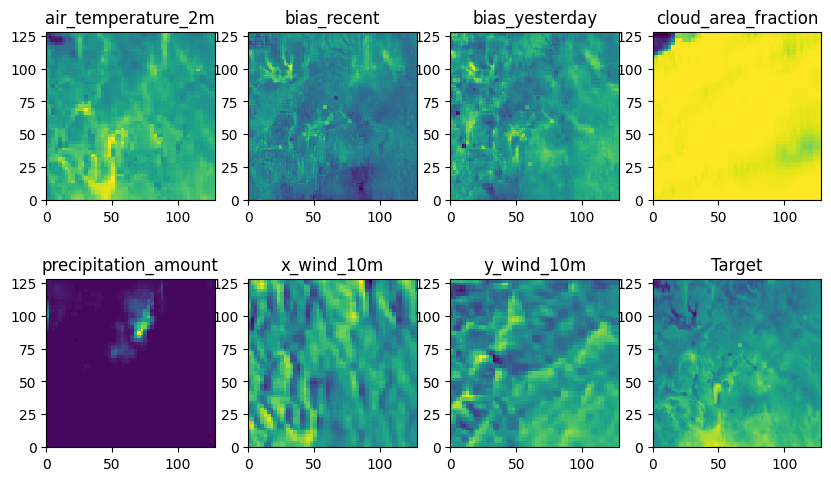

In [4]:
index_date = 0
target = ds["target"].values
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [10, 6]
for i, name in enumerate(unique_predictor_names):
    plt.subplot(2, 4, i + 1)
    index = np.where(names == name)[0][0]
    plt.pcolormesh(ds["predictors"][index_date, :, :, index], shading="auto", rasterized=True)
    plt.gca().set_aspect(1)
    plt.title(name)
plt.subplot(2, 4, 8)
plt.pcolormesh(target[index_date, :, :, 0], shading="auto", rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target")

## Example ML solution
### Normalizing the predictors

First we normalize the predictors, by subtractng the mean and dividing by the standard deviation:

In [5]:
raw_forecast = np.copy(ds["predictors"][:, :, :, 0:num_leadtimes])
predictors = np.copy(ds["predictors"].values)
num_predictors = predictors.shape[3]
for p in range(num_predictors):
    predictors[:, :, :, p] -= np.nanmean(predictors[:, :, :, p])
    predictors[:, :, :, p] /= np.nanstd(predictors[:, :, :, p])

### Defining the loss function
We use the quantile loss function, by scoring each of the three output quantiles of the model:

In [6]:
global num_leadtimes
def quantile_loss_function(y_true, y_pred):
    err0 = y_true - y_pred[:, :, :, 0:num_leadtimes]
    err1 = y_true - y_pred[:, :, :, num_leadtimes:(2*num_leadtimes)]
    err2 = y_true - y_pred[:, :, :, (2*num_leadtimes):(3*num_leadtimes)]
    qtloss0 = (0.5 - tf.cast((err0 < 0), tf.float32)) * err0
    qtloss1 = (0.1 - tf.cast((err1 < 0), tf.float32)) * err1
    qtloss2 = (0.9 - tf.cast((err2 < 0), tf.float32)) * err2
    return K.mean(qtloss0 + qtloss1 + qtloss2)

### Setting up the model
The model takes a gridded predictor set as input and outputs gridded fields for each leadtime and for three quantiles. The tempearture forecast on yr.no has both a deterministic best guess and a 10-90% confidence interval. We want the model to predict all three parameters simultaneously.

In [7]:
import keras
import tensorflow as tf
import keras.backend as K

num_quantiles = 3
num_outputs = num_quantiles * num_leadtimes

model = keras.Sequential()
model.add(keras.layers.InputLayer(predictors.shape[1:]))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(num_outputs))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-2), loss = quantile_loss_function)
model.summary()

2021-08-04 20:43:44.229971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-08-04 20:43:44.229992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128, 24)      1200      
_________________________________________________________________
dense_1 (Dense)              (None, 128, 128, 24)      600       
_________________________________________________________________
dense_2 (Dense)              (None, 128, 128, 24)      600       
_________________________________________________________________
dense_3 (Dense)              (None, 128, 128, 24)      600       
_________________________________________________________________
dense_4 (Dense)              (None, 128, 128, 24)      600       
_________________________________________________________________
dense_5 (Dense)              (None, 128, 128, 24)      600       
Total params: 4,200
Trainable params: 4,200
Non-trainable params: 0
______________________________________________________

2021-08-04 20:43:46.235934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-08-04 20:43:46.235957: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-04 20:43:46.235973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc5088): /proc/driver/nvidia/version does not exist
2021-08-04 20:43:46.236178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training the model
We will split the dataset into a training and evaluation set, based on the record dimension.

In [8]:
Itrain = range(predictors.shape[0]//2)
Ieval = range(predictors.shape[0]//2, predictors.shape[0])
num_epochs = 50
batch_size = 4
model.fit(predictors[Itrain, ...], target[Itrain, ...], epochs=num_epochs, batch_size=batch_size)

2021-08-04 20:43:51.512053: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2337800192 exceeds 10% of free system memory.
2021-08-04 20:43:52.904155: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-04 20:43:52.924976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


Epoch 1/50
182/182 [==============================] - 15s 39ms/step - loss: 5.6099
Epoch 2/50
182/182 [==============================] - 7s 39ms/step - loss: 1.5900
Epoch 3/50
182/182 [==============================] - 7s 39ms/step - loss: 1.6465
Epoch 4/50
182/182 [==============================] - 7s 39ms/step - loss: 1.5188
Epoch 5/50
182/182 [==============================] - 7s 39ms/step - loss: 1.4671
Epoch 6/50
182/182 [==============================] - 7s 39ms/step - loss: 1.4558
Epoch 7/50
182/182 [==============================] - 7s 39ms/step - loss: 1.4523
Epoch 8/50
182/182 [==============================] - 7s 38ms/step - loss: 1.2859
Epoch 9/50
182/182 [==============================] - 7s 39ms/step - loss: 1.3220
Epoch 10/50
182/182 [==============================] - 7s 40ms/step - loss: 1.2476
Epoch 11/50
182/182 [==============================] - 7s 40ms/step - loss: 1.3014
Epoch 12/50
182/182 [==============================] - 7s 40ms/step - loss: 1.3814
Epoch 13/50


### Predict output

In [9]:
output = model.predict(predictors[Ieval, ...])

2021-08-04 20:50:29.088439: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2341011456 exceeds 10% of free system memory.
2021-08-04 20:50:32.663004: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1146617856 exceeds 10% of free system memory.


## Model evaluation and visualization

### Evaluating the model
First, lets compare the mean absolute error of the raw forecast and the ML-forecast of the median

In [10]:
import numpy as np
print("Raw model MAE:", np.nanmean(np.abs(raw_forecast[Ieval, ...] - target[Ieval, ...])), "°C")
print("ML MAE:", np.nanmean(np.abs(output[:, :, :, 0:num_leadtimes] - target[Ieval, ...])), "°C")

Raw model MAE: 1.1301652 °C
ML MAE: 1.0244911 °C


Next, we can plot the MAE as a function of leadtime:

Text(0, 0.5, 'Mean absolute error (°C)')

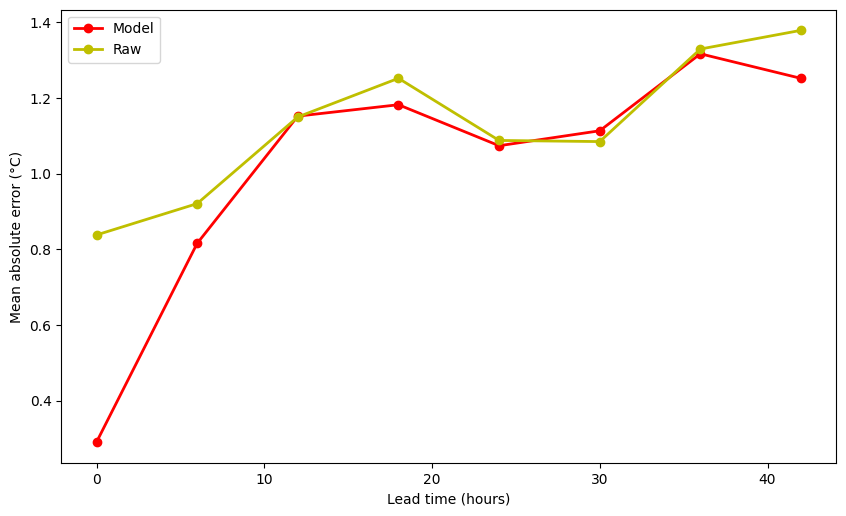

In [11]:
x = ds["leadtime"].astype(float) / 3600 / 1e9
plt.plot(x, [np.nanmean(np.abs(output[:, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'ro-', lw=2, label="Model")
plt.plot(x, [np.nanmean(np.abs(raw_forecast[Ieval, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'yo-', lw=2, label="Raw")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Mean absolute error (°C)")


### Visualizing the results as timeseries
We can visualize the output as a timeseries. We will pick an example point (Oslo).

Text(0, 0.5, 'Air temperature (°C)')

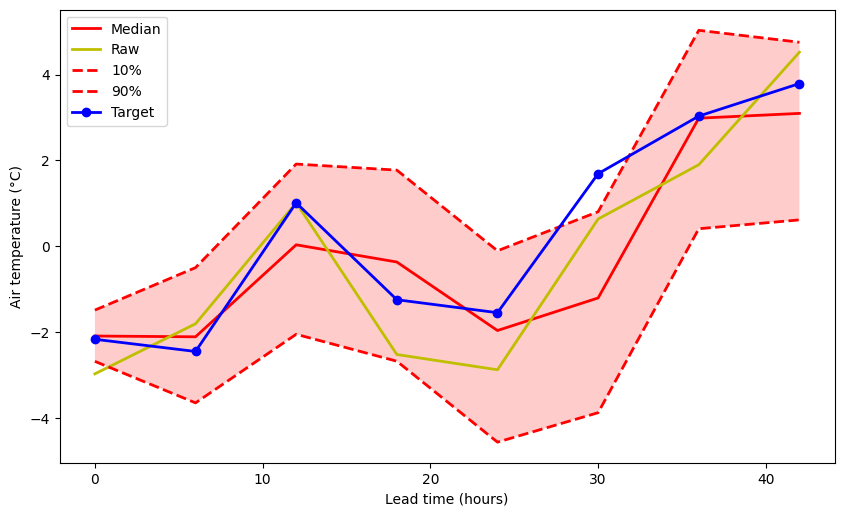

In [12]:
Y = 55
X = 55
plt.plot(x, output[0, Y, X, 0:num_leadtimes], 'r-', lw=2, label="Median")
plt.plot(x, raw_forecast[Ieval[0], Y, X, 0:num_leadtimes], 'y-', lw=2, label="Raw")
lower = output[0, Y, X,num_leadtimes:2*num_leadtimes]
upper = output[0, Y, X, 2*num_leadtimes:3*num_leadtimes]
plt.plot(x, lower, 'r--', lw=2, label="10%")
plt.plot(x, upper, 'r--', lw=2, label="90%")
xx = np.concatenate((x, x[::-1]))
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lower, upper[::-1])), color='r', alpha=0.2, linewidth=0)
plt.plot(x, target[Ieval[0], Y, X, :], 'bo-', lw=2, label="Target")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Air temperature (°C)")

### Visualizing the results on a map

Text(0.5, 1.0, 'Target (median)')

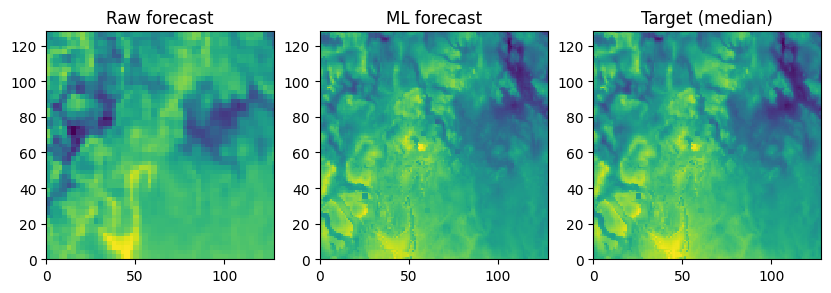

In [13]:
plt.subplot(1, 3, 1)
plt.pcolormesh(raw_forecast[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Raw forecast")

plt.subplot(1, 3, 2)
plt.pcolormesh(output[0, :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("ML forecast")

plt.subplot(1, 3, 3)
plt.pcolormesh(target[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target (median)")